# StoveTeam Charitable Giving Analysis

**Converted from R Markdown to Python**

This notebook analyzes charitable giving to StoveTeam across three time periods (May 2023, Nov 2023, May 2024). It merges donor transaction data with state-level demographic data to run Logit regressions.

---

## 1. Setup and Library Imports

In [1]:
# Install required packages (uncomment if running in Google Colab)
# !pip install pandas numpy statsmodels seaborn matplotlib scipy

# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import Logit
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Data Loading

Load the accounts, gifts, and state characteristics CSV files for each time period.

In [2]:
# ============================================================
# DATA LOADING
# ============================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Correct path based on your folder structure:
# My Drive > Research Methods > Paper Publish > StoveTeam_Analysis
base_path = '/content/drive/MyDrive/Research Methods/Paper Publish/StoveTeam_Analysis/'

# Verify the path exists and show files
import os
print("Files in folder:")
print(os.listdir(base_path))

Mounted at /content/drive
Files in folder:
['usedata_accts_may23.csv', 'usedata_gifts_may23.csv', 'usedata_accts_nov23.csv', 'usedata_gifts_nov23.csv', 'usedata_accts_may24.csv', 'usedata_gifts_may24.csv', 'state_charac.csv']


In [3]:
import pandas as pd

# Load May 2023 data
accts_may23 = pd.read_csv(f'{base_path}usedata_accts_may23.csv')
gifts_may23 = pd.read_csv(f'{base_path}usedata_gifts_may23.csv')

# Load November 2023 data
accts_nov23 = pd.read_csv(f'{base_path}usedata_accts_nov23.csv')
gifts_nov23 = pd.read_csv(f'{base_path}usedata_gifts_nov23.csv')

# Load May 2024 data
accts_may24 = pd.read_csv(f'{base_path}usedata_accts_may24.csv')
gifts_may24 = pd.read_csv(f'{base_path}usedata_gifts_may24.csv')

# Load state characteristics data
state_charac = pd.read_csv(f'{base_path}state_charac.csv')

print("✅ All data files loaded successfully!")
print(f"accts_may23: {accts_may23.shape}")
print(f"gifts_may23: {gifts_may23.shape}")
print(f"accts_nov23: {accts_nov23.shape}")
print(f"gifts_nov23: {gifts_nov23.shape}")
print(f"accts_may24: {accts_may24.shape}")
print(f"gifts_may24: {gifts_may24.shape}")
print(f"state_charac: {state_charac.shape}")

✅ All data files loaded successfully!
accts_may23: (6174, 15)
gifts_may23: (180, 10)
accts_nov23: (6270, 15)
gifts_nov23: (269, 10)
accts_may24: (6471, 15)
gifts_may24: (152, 10)
state_charac: (51, 18)


## 3. Data Merging

Merge accounts and gifts files using a full (outer) join on `acct.id` and `period`.

In [4]:
# ============================================================
# DATA MERGING (full_join equivalent in pandas = outer merge)
# ============================================================

# Merge accounts and gifts for May 2023
all_may23 = pd.merge(accts_may23, gifts_may23, on=['acct.id', 'period'], how='outer')

# Merge accounts and gifts for November 2023
all_nov23 = pd.merge(accts_nov23, gifts_nov23, on=['acct.id', 'period'], how='outer')

# Merge accounts and gifts for May 2024
all_may24 = pd.merge(accts_may24, gifts_may24, on=['acct.id', 'period'], how='outer')

print(f"May 2023 merged shape: {all_may23.shape}")
print(f"November 2023 merged shape: {all_nov23.shape}")
print(f"May 2024 merged shape: {all_may24.shape}")

May 2023 merged shape: (6249, 23)
November 2023 merged shape: (6345, 23)
May 2024 merged shape: (6526, 23)


In [5]:
# Check if data was loaded correctly
print("Checking loaded data...")
print(f"accts_may23 exists: {'accts_may23' in dir()}")
print(f"gifts_may23 exists: {'gifts_may23' in dir()}")

# If they exist, run the merge
if 'accts_may23' in dir() and 'gifts_may23' in dir():
    # Merge accounts and gifts for May 2023
    all_may23 = pd.merge(accts_may23, gifts_may23, on=['acct.id', 'period'], how='outer')

    # Merge accounts and gifts for November 2023
    all_nov23 = pd.merge(accts_nov23, gifts_nov23, on=['acct.id', 'period'], how='outer')

    # Merge accounts and gifts for May 2024
    all_may24 = pd.merge(accts_may24, gifts_may24, on=['acct.id', 'period'], how='outer')

    print(f"\n✅ Merge complete!")
    print(f"all_may23 shape: {all_may23.shape}")
    print(f"all_nov23 shape: {all_nov23.shape}")
    print(f"all_may24 shape: {all_may24.shape}")
else:
    print("❌ Data not loaded. Please run the data loading cell first.")

Checking loaded data...
accts_may23 exists: True
gifts_may23 exists: True

✅ Merge complete!
all_may23 shape: (6249, 23)
all_nov23 shape: (6345, 23)
all_may24 shape: (6526, 23)


## 4. Feature Engineering - Date Calculations

Calculate giving length (time from first gift to last gift) and gift duration.

In [6]:
# ============================================================
# DATE PARSING AND GIVING LENGTH CALCULATION
# Replicates lubridate's mdy() and interval/time_length functions
# ============================================================

def calculate_give_length(df):
    """
    Calculate the length of time from first gift to last gift in months.
    Replicates R's: interval(mdy(gift.first.date), mdy(gift.last.date)) -> time_length("months")
    """
    df = df.copy()

    # Parse dates using pandas.to_datetime (handles M/D/Y format)
    df['gift.first.date.parsed'] = pd.to_datetime(df['gift.first.date'], format='%m/%d/%Y', errors='coerce')
    df['gift.last.date.parsed'] = pd.to_datetime(df['gift.last.date'], format='%m/%d/%Y', errors='coerce')

    # Calculate the interval in months
    # Using days difference divided by average days per month (30.44)
    df['acct.give.length'] = (
        (df['gift.last.date.parsed'] - df['gift.first.date.parsed']).dt.days / 30.44
    )

    return df

# Apply to all datasets
all_may23 = calculate_give_length(all_may23)
all_nov23 = calculate_give_length(all_nov23)
all_may24 = calculate_give_length(all_may24)

print("Giving length calculated for all periods.")

Giving length calculated for all periods.


In [7]:
# ============================================================
# CALCULATE gift.last.amount.1
# Set to NA if acct.give.length is NA
# ============================================================

def calculate_gift_last_amount_1(df):
    """
    Create gift.last.amount.1: set to gift.last.amount if acct.give.length exists, else NA
    """
    df = df.copy()
    df['gift.last.amount.1'] = np.where(
        df['acct.give.length'].isna(),
        np.nan,
        df['gift.last.amount']
    )
    return df

all_may23 = calculate_gift_last_amount_1(all_may23)
all_nov23 = calculate_gift_last_amount_1(all_nov23)
all_may24 = calculate_gift_last_amount_1(all_may24)

print("gift.last.amount.1 calculated for all periods.")

gift.last.amount.1 calculated for all periods.


In [8]:
# ============================================================
# CALCULATE GIFT DURATION AND GIFT AMOUNTS
# ============================================================

def calculate_gift_metrics(df):
    """
    Calculate gift.duration.1, gift.amount.1, gift.amount.1mon.1, gift.amount.3mon.1, and gift.mean
    Replicates the R logic for date interval and conditional amount assignment
    """
    df = df.copy()

    # Parse date.sent and date.close
    df['date.sent.parsed'] = pd.to_datetime(df['date.sent'], format='%m/%d/%Y', errors='coerce')
    df['date.close.parsed'] = pd.to_datetime(df['date.close'], format='%m/%d/%Y', errors='coerce')

    # Calculate gift.duration.1 in days
    df['gift.duration.1'] = (df['date.close.parsed'] - df['date.sent.parsed']).dt.days

    # Create copies and fill NA with 0 for amount columns
    df['gift.amount.1'] = df['gift.amount'].fillna(0)
    df['gift.amount.1mon.1'] = df['gift.amount.1mon'].fillna(0)
    df['gift.amount.3mon.1'] = df['gift.amount.3mon'].fillna(0)

    # Create chk.1: 1 if appeal.sent.yes >= 0 OR email.sent.yes >= 0, else NA
    df['chk.1'] = np.where(
        (df['appeal.sent.yes'] >= 0) | (df['email.sent.yes'] >= 0),
        1,
        np.nan
    )

    # Set amounts to NA where chk.1 is not 1
    df['gift.amount.1'] = np.where(df['chk.1'] == 1, df['gift.amount.1'], np.nan)
    df['gift.amount.1mon.1'] = np.where(df['chk.1'] == 1, df['gift.amount.1mon.1'], np.nan)
    df['gift.amount.3mon.1'] = np.where(df['chk.1'] == 1, df['gift.amount.3mon.1'], np.nan)

    # Calculate gift.mean = gift.amount.1 / gift.number
    df['gift.mean'] = df['gift.amount.1'] / df['gift.number']

    return df

all_may23 = calculate_gift_metrics(all_may23)
all_nov23 = calculate_gift_metrics(all_nov23)
all_may24 = calculate_gift_metrics(all_may24)

print("Gift duration and metrics calculated for all periods.")

Gift duration and metrics calculated for all periods.


## 5. Feature Engineering - Dependent Variable

Create the binary outcome variable `gift.yes` indicating whether a donation was made.

In [9]:
# ============================================================
# CREATE DEPENDENT VARIABLE: gift.yes
# 1 if gift.amount.1 > 0, else 0
# ============================================================

all_may23['gift.yes'] = np.where(all_may23['gift.amount.1'] > 0, 1, 0)
all_nov23['gift.yes'] = np.where(all_nov23['gift.amount.1'] > 0, 1, 0)
all_may24['gift.yes'] = np.where(all_may24['gift.amount.1'] > 0, 1, 0)

print("Dependent variable 'gift.yes' created for all periods.")
print(f"\nMay 2023 gift.yes distribution:\n{all_may23['gift.yes'].value_counts()}")
print(f"\nNovember 2023 gift.yes distribution:\n{all_nov23['gift.yes'].value_counts()}")
print(f"\nMay 2024 gift.yes distribution:\n{all_may24['gift.yes'].value_counts()}")

Dependent variable 'gift.yes' created for all periods.

May 2023 gift.yes distribution:
gift.yes
0    6148
1     101
Name: count, dtype: int64

November 2023 gift.yes distribution:
gift.yes
0    6150
1     195
Name: count, dtype: int64

May 2024 gift.yes distribution:
gift.yes
0    6430
1      96
Name: count, dtype: int64


## 6. Feature Engineering - Z-Score Calculations for State Characteristics

Calculate Z-scores for income, age, education, and foreign-born population.

In [10]:
# ============================================================
# LOAD AND CLEAN STATE CHARACTERISTICS DATA
# ============================================================

# Load state_charac with proper handling of numeric columns
state_charac = pd.read_csv(f'{base_path}state_charac.csv')

# Check the columns and data types
print("Original state_charac columns:")
print(state_charac.dtypes)
print("\nFirst few rows:")
print(state_charac.head())

# Function to clean numeric columns (remove commas and convert to float)
def clean_numeric_column(col):
    if col.dtype == 'object':  # If it's a string column
        # Remove commas and convert to numeric
        return pd.to_numeric(col.astype(str).str.replace(',', ''), errors='coerce')
    return col

# List of columns that should be numeric
numeric_cols = ['income', 'age.55_64', 'age.65_74', 'age.75_up',
                'ed.assoc.lessBA', 'ed.BA.more', 'foreign.born']

# Clean each numeric column
for col in numeric_cols:
    if col in state_charac.columns:
        state_charac[col] = clean_numeric_column(state_charac[col])

print("\nCleaned state_charac data types:")
print(state_charac.dtypes)
print("\nFirst few rows after cleaning:")
print(state_charac.head())

Original state_charac columns:
state                object
appeal.state         object
loc.division         object
loc.division.num      int64
loc.region           object
loc.region.num        int64
own.home            float64
income               object
female              float64
foreign.born        float64
ed.hsgrad.less      float64
ed.assoc.lessBA     float64
ed.BA.more          float64
age.25_34           float64
age.35_54           float64
age.55_64           float64
age.65_74           float64
age.75_up           float64
dtype: object

First few rows:
        state appeal.state        loc.division  loc.division.num loc.region  \
0     Alabama           AL  East South Central                 6      South   
1      Alaska           AK            Pacific                  9       West   
2     Arizona           AZ            Mountain                 8       West   
3    Arkansas           AR  West South Central                 7      South   
4  California           CA            P

In [11]:
# ============================================================
# Z-SCORE CALCULATIONS FOR STATE CHARACTERISTICS
# Exactly replicating R's (x - mean(x)) / sd(x)
# ============================================================

# 1. Z-score for income
state_charac['z.income'] = (
    (state_charac['income'] - state_charac['income'].mean()) / state_charac['income'].std()
)

# 2. Calculate average age across older age ranges, then Z-score
state_charac['avg_age'] = (
    state_charac['age.55_64'] + state_charac['age.65_74'] + state_charac['age.75_up']
) / 3

state_charac['z.age'] = (
    (state_charac['avg_age'] - state_charac['avg_age'].mean()) / state_charac['avg_age'].std()
)

# 3. Calculate higher education (associate + BA or more), then Z-score
state_charac['higher_ed'] = state_charac['ed.assoc.lessBA'] + state_charac['ed.BA.more']

state_charac['z.edu'] = (
    (state_charac['higher_ed'] - state_charac['higher_ed'].mean()) / state_charac['higher_ed'].std()
)

# 4. Z-score for foreign-born population
state_charac['foreign.born.z'] = (
    (state_charac['foreign.born'] - state_charac['foreign.born'].mean()) / state_charac['foreign.born'].std()
)

print("Z-scores calculated for state characteristics:")
print(state_charac[['appeal.state', 'z.income', 'z.age', 'z.edu', 'foreign.born.z']].head(10))

Z-scores calculated for state characteristics:
  appeal.state  z.income   z.age   z.edu  foreign.born.z
0           AL   -1.2002  0.1395 -1.1291         -0.9472
1           AK    1.1112 -1.5615  0.0122         -0.3464
2           AZ    0.0100  0.0171  0.2374          0.5482
3           AR   -1.5449 -0.1053 -1.8182         -0.7303
4           CA    1.3898 -0.8882  0.0083          2.7392
5           CO    1.2071 -1.0009  1.7096         -0.0188
6           CT    1.1362  0.6292  0.2824          0.9643
7           DE    0.6279  1.3928 -0.0700          0.0423
8           DC    2.1598 -2.5924  3.1446          0.8358
9           FL   -0.4178  1.4346 -0.2560          1.9264


In [12]:
# ============================================================
# JOIN STATE CHARACTERISTICS TO MAIN DATA
# ============================================================

# Select relevant columns from state_charac
state_vars = state_charac[['appeal.state', 'z.income', 'z.age', 'z.edu', 'foreign.born.z']]

# Left join to add state characteristics to each period's data
all_may23 = pd.merge(all_may23, state_vars, on='appeal.state', how='left')
all_nov23 = pd.merge(all_nov23, state_vars, on='appeal.state', how='left')
all_may24 = pd.merge(all_may24, state_vars, on='appeal.state', how='left')

print("State characteristics merged with all periods.")

State characteristics merged with all periods.


## 7. Feature Engineering - Appeal Characteristics and Binary Flags

In [13]:
# ============================================================
# CREATE APPEAL CHARACTERISTIC VARIABLES
# ============================================================

def create_appeal_variables(df):
    """
    Create binary flags for appeal characteristics based on period values.
    """
    df = df.copy()

    # appeal.health: 1 if period == 3, else 0
    df['appeal.health'] = np.where(df['period'] == 3, 1, 0)

    # appeal.responsibility: 1 if period == 2 OR period == 3, else 0
    df['appeal.responsibility'] = np.where(
        (df['period'] == 2) | (df['period'] == 3), 1, 0
    )

    # appeal.suggest.amt: 1 if period == 1 OR period == 2, else 0
    df['appeal.suggest.amt'] = np.where(
        (df['period'] == 1) | (df['period'] == 2), 1, 0
    )

    # appeal.nov: 1 if period == 2 (November/Holiday appeal), else 0
    df['appeal.nov'] = np.where(df['period'] == 2, 1, 0)

    return df

all_may23 = create_appeal_variables(all_may23)
all_nov23 = create_appeal_variables(all_nov23)
all_may24 = create_appeal_variables(all_may24)

print("Appeal characteristic variables created.")

Appeal characteristic variables created.


In [14]:
# ============================================================
# CREATE PAST DONATION FLAG
# ============================================================

# gift.past.yes: 1 if gift.last.amount.1 > 0, else 0
all_may23['gift.past.yes'] = np.where(all_may23['gift.last.amount.1'] > 0, 1, 0)
all_nov23['gift.past.yes'] = np.where(all_nov23['gift.last.amount.1'] > 0, 1, 0)
all_may24['gift.past.yes'] = np.where(all_may24['gift.last.amount.1'] > 0, 1, 0)

print("Past donation flag 'gift.past.yes' created.")

Past donation flag 'gift.past.yes' created.


In [15]:
# ============================================================
# CREATE MESSAGE QUALITY VARIABLE
# Average of clarity, credibility, and persuasiveness scores (1-5)
# ============================================================

# Period 1 (May 2023): scores 4, 3, 3
all_may23['appeal.message.quality'] = (4 + 3 + 3) / 3

# Period 2 (November 2023): scores 5, 4, 4
all_nov23['appeal.message.quality'] = (5 + 4 + 4) / 3

# Period 3 (May 2024): scores 3, 3, 3
all_may24['appeal.message.quality'] = (3 + 3 + 3) / 3

print("Message quality variable created.")
print(f"May 2023 message quality: {all_may23['appeal.message.quality'].iloc[0]:.2f}")
print(f"November 2023 message quality: {all_nov23['appeal.message.quality'].iloc[0]:.2f}")
print(f"May 2024 message quality: {all_may24['appeal.message.quality'].iloc[0]:.2f}")

Message quality variable created.
May 2023 message quality: 3.33
November 2023 message quality: 4.33
May 2024 message quality: 3.00


In [16]:
# ============================================================
# CREATE STATE TAX INCENTIVE VARIABLE
# ============================================================

# States with tax incentives for charitable giving
tax_incentive_states = [
    "AL", "AZ", "AR", "CA", "CO", "DE", "DC", "GA", "HI", "ID",
    "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MN", "MS", "MO",
    "MT", "NE", "NM", "NY", "NC", "OK", "OR", "SC", "VA", "WI"
]

# Foreign/Military codes to set as NA
foreign_codes = ["ZZ", "AA", "AE", "AP"]

def create_tax_incentive(df):
    """
    Create State_Tax_Incentive_i:
    - 1 if state has tax incentive
    - 0 if state doesn't have tax incentive
    - NA if state is NA or is a foreign/military code
    """
    df = df.copy()

    conditions = [
        df['appeal.state'].isin(tax_incentive_states),
        df['appeal.state'].isna() | df['appeal.state'].isin(foreign_codes)
    ]
    choices = [1, np.nan]

    df['State_Tax_Incentive_i'] = np.select(conditions, choices, default=0)

    return df

all_may23 = create_tax_incentive(all_may23)
all_nov23 = create_tax_incentive(all_nov23)
all_may24 = create_tax_incentive(all_may24)

print("State tax incentive variable created.")

State tax incentive variable created.


## 8. Data Trimming - Remove Missing Values for Analysis

In [17]:
# ============================================================
# DEFINE ANALYSIS VARIABLES AND TRIM DATA
# ============================================================

# List of relevant variables for analysis
analysis_vars = [
    "gift.amount.1", "gift.yes",  # Dependent variables
    "z.income", "z.age", "foreign.born.z", "z.edu",  # State demographics
    "appeal.health", "appeal.responsibility",
    "appeal.suggest.amt", "appeal.nov",
    "gift.past.yes", "appeal.message.quality", "State_Tax_Incentive_i"
]

# Trim datasets by dropping rows with NA in analysis variables
all_may23_trimmed = all_may23.dropna(subset=analysis_vars).copy()
all_nov23_trimmed = all_nov23.dropna(subset=analysis_vars).copy()
all_may24_trimmed = all_may24.dropna(subset=analysis_vars).copy()

print(f"Original May 2023 shape: {all_may23.shape}")
print(f"Trimmed May 2023 shape: {all_may23_trimmed.shape}")
print()
print(f"Original November 2023 shape: {all_nov23.shape}")
print(f"Trimmed November 2023 shape: {all_nov23_trimmed.shape}")
print()
print(f"Original May 2024 shape: {all_may24.shape}")
print(f"Trimmed May 2024 shape: {all_may24_trimmed.shape}")

Original May 2023 shape: (6249, 47)
Trimmed May 2023 shape: (1434, 47)

Original November 2023 shape: (6345, 47)
Trimmed November 2023 shape: (1469, 47)

Original May 2024 shape: (6526, 47)
Trimmed May 2024 shape: (1586, 47)


## 9. Descriptive Statistics

In [18]:
# ============================================================
# DESCRIPTIVE STATISTICS
# Equivalent to stargazer summary statistics
# ============================================================

def descriptive_stats(df, title, vars_list):
    """
    Generate descriptive statistics similar to stargazer output.
    """
    print("=" * 80)
    print(title)
    print("=" * 80)

    stats_df = df[vars_list].describe(percentiles=[.25, .5, .75]).T
    stats_df['IQR'] = stats_df['75%'] - stats_df['25%']

    print(stats_df[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']].round(2))
    print()
    return stats_df

# Generate descriptive statistics for each period
stats_may23 = descriptive_stats(all_may23_trimmed, "Table 1A. Descriptive Statistics: May 2023 Appeal", analysis_vars)
stats_nov23 = descriptive_stats(all_nov23_trimmed, "Table 1B. Descriptive Statistics: November 2023 Appeal", analysis_vars)
stats_may24 = descriptive_stats(all_may24_trimmed, "Table 1C. Descriptive Statistics: May 2024 Appeal", analysis_vars)

Table 1A. Descriptive Statistics: May 2023 Appeal
                           count    mean     std     min     25%    50%  \
gift.amount.1          1434.0000 15.0300 91.7200  0.0000  0.0000 0.0000   
gift.yes               1434.0000  0.0700  0.2500  0.0000  0.0000 0.0000   
z.income               1434.0000  0.3800  0.6600 -1.7700  0.1000 0.1000   
z.age                  1434.0000 -0.0700  0.6400 -3.0400 -0.5700 0.2600   
foreign.born.z         1434.0000  0.4800  0.9600 -1.1900  0.0400 0.0400   
z.edu                  1434.0000  0.6500  0.6100 -1.8300  0.2200 0.9400   
appeal.health          1434.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
appeal.responsibility  1434.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
appeal.suggest.amt     1434.0000  1.0000  0.0000  1.0000  1.0000 1.0000   
appeal.nov             1434.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
gift.past.yes          1434.0000  0.9600  0.2000  0.0000  1.0000 1.0000   
appeal.message.quality 1434.0000  3.3300  0.0000  

## 10. Correlation Matrices

In [19]:
# ============================================================
# PAIRWISE CORRELATION TABLES
# ============================================================

# Variables for correlation analysis (continuous variables only)
vars_cor = ["gift.amount.1", "z.income", "z.age", "foreign.born.z", "z.edu"]

def print_correlation_table(df, title, vars_list):
    """
    Print a correlation matrix.
    """
    print("=" * 80)
    print(title)
    print("=" * 80)
    corr_matrix = df[vars_list].corr().round(3)
    print(corr_matrix)
    print()
    return corr_matrix

cor_may23 = print_correlation_table(all_may23_trimmed, "Table 2A: Pairwise Correlations: May 2023 Appeal", vars_cor)
cor_nov23 = print_correlation_table(all_nov23_trimmed, "Table 2B: Pairwise Correlations: November 2023 Appeal", vars_cor)
cor_may24 = print_correlation_table(all_may24_trimmed, "Table 2C: Pairwise Correlations: May 2024 Appeal", vars_cor)

Table 2A: Pairwise Correlations: May 2023 Appeal
                gift.amount.1  z.income   z.age  foreign.born.z   z.edu
gift.amount.1          1.0000   -0.0170  0.0440         -0.0200 -0.0120
z.income              -0.0170    1.0000 -0.4690          0.7170  0.2490
z.age                  0.0440   -0.4690  1.0000         -0.4350  0.1430
foreign.born.z        -0.0200    0.7170 -0.4350          1.0000 -0.2810
z.edu                 -0.0120    0.2490  0.1430         -0.2810  1.0000

Table 2B: Pairwise Correlations: November 2023 Appeal
                gift.amount.1  z.income   z.age  foreign.born.z   z.edu
gift.amount.1          1.0000   -0.0270  0.0260         -0.0270 -0.0020
z.income              -0.0270    1.0000 -0.4710          0.7160  0.2570
z.age                  0.0260   -0.4710  1.0000         -0.4310  0.1310
foreign.born.z        -0.0270    0.7160 -0.4310          1.0000 -0.2740
z.edu                 -0.0020    0.2570  0.1310         -0.2740  1.0000

Table 2C: Pairwise Correlations

## 11. Cross-Tabulations

In [20]:
# ============================================================
# CROSS-TABULATIONS
# ============================================================

vars_xtab = [
    "appeal.health", "appeal.responsibility",
    "appeal.suggest.amt", "appeal.nov",
    "gift.past.yes", "State_Tax_Incentive_i"
]

def create_xtabs(df, vars_list, table_name):
    """
    Generate cross-tabulations for each variable against gift.yes.
    """
    print("=" * 80)
    print(table_name)
    print("=" * 80)

    for var in vars_list:
        print(f"\nCross-tabulation for {var}:")
        xtab = pd.crosstab(df['gift.yes'], df[var], margins=True)
        print(xtab)
    print()

create_xtabs(all_may23_trimmed, vars_xtab, "Table 2A: Cross-tabulations: May 2023 Appeal")
create_xtabs(all_nov23_trimmed, vars_xtab, "Table 2B: Cross-tabulations: November 2023 Appeal")
create_xtabs(all_may24_trimmed, vars_xtab, "Table 2C: Cross-tabulations: May 2024 Appeal")

Table 2A: Cross-tabulations: May 2023 Appeal

Cross-tabulation for appeal.health:
appeal.health     0   All
gift.yes                 
0              1337  1337
1                97    97
All            1434  1434

Cross-tabulation for appeal.responsibility:
appeal.responsibility     0   All
gift.yes                         
0                      1337  1337
1                        97    97
All                    1434  1434

Cross-tabulation for appeal.suggest.amt:
appeal.suggest.amt     1   All
gift.yes                      
0                   1337  1337
1                     97    97
All                 1434  1434

Cross-tabulation for appeal.nov:
appeal.nov     0   All
gift.yes              
0           1337  1337
1             97    97
All         1434  1434

Cross-tabulation for gift.past.yes:
gift.past.yes   0     1   All
gift.yes                     
0              57  1280  1337
1               0    97    97
All            57  1377  1434

Cross-tabulation for State_Tax_Incentiv

## 12. Visualizations

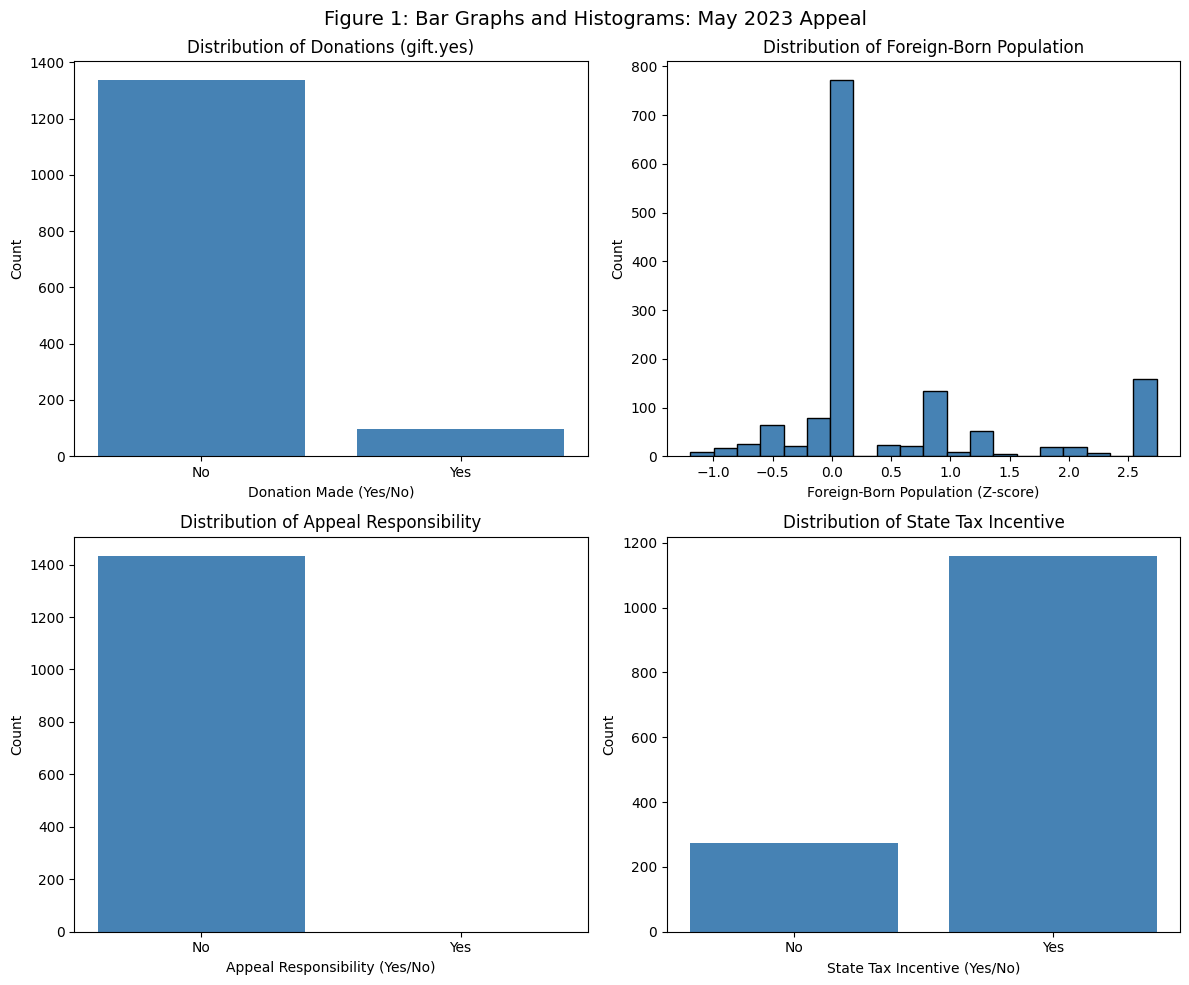

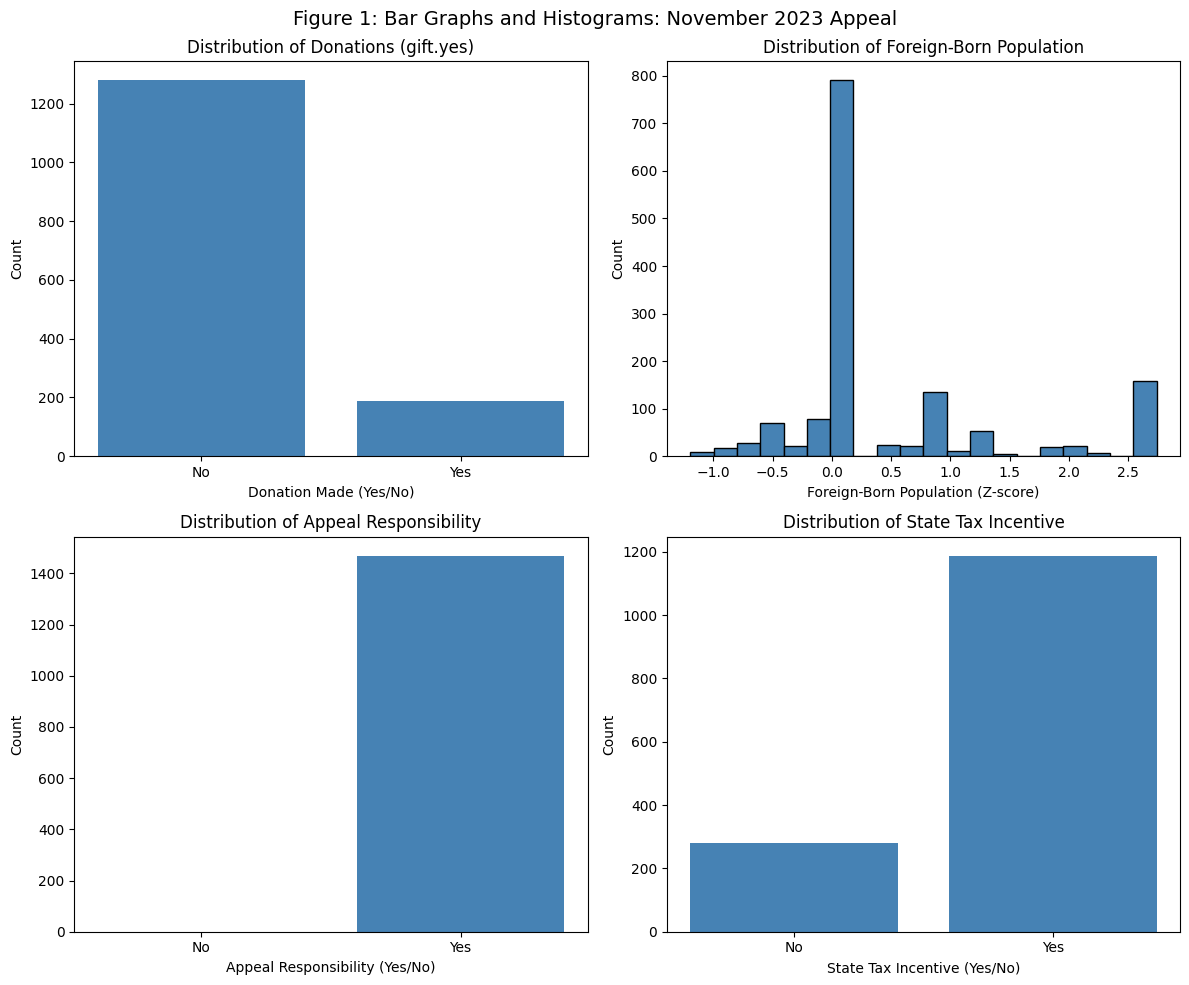

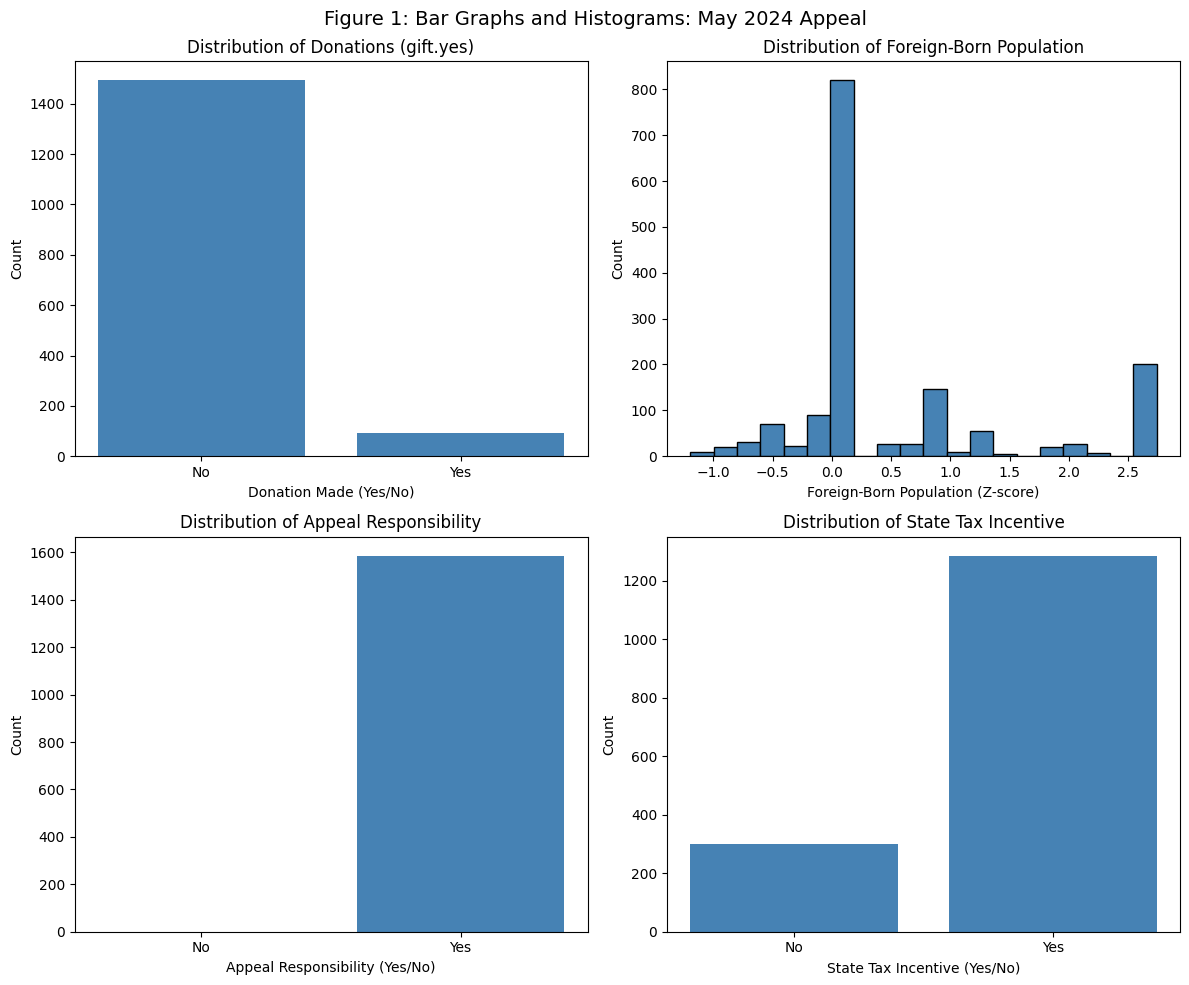

In [21]:
# ============================================================
# FIGURE 1: BAR GRAPHS AND HISTOGRAMS
# ============================================================

def create_figure1(df, period_name):
    """
    Create bar graphs and histograms for key variables.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Figure 1: Bar Graphs and Histograms: {period_name}', fontsize=14)

    # Plot 1: Distribution of Donations (gift.yes)
    ax1 = axes[0, 0]
    gift_counts = df['gift.yes'].value_counts().sort_index()
    ax1.bar(['No', 'Yes'], [gift_counts.get(0, 0), gift_counts.get(1, 0)], color='steelblue')
    ax1.set_title('Distribution of Donations (gift.yes)')
    ax1.set_xlabel('Donation Made (Yes/No)')
    ax1.set_ylabel('Count')

    # Plot 2: Distribution of Foreign-Born Population
    ax2 = axes[0, 1]
    ax2.hist(df['foreign.born.z'].dropna(), bins=20, color='steelblue', edgecolor='black')
    ax2.set_title('Distribution of Foreign-Born Population')
    ax2.set_xlabel('Foreign-Born Population (Z-score)')
    ax2.set_ylabel('Count')

    # Plot 3: Distribution of Appeal Responsibility
    ax3 = axes[1, 0]
    resp_counts = df['appeal.responsibility'].value_counts().sort_index()
    ax3.bar(['No', 'Yes'], [resp_counts.get(0, 0), resp_counts.get(1, 0)], color='steelblue')
    ax3.set_title('Distribution of Appeal Responsibility')
    ax3.set_xlabel('Appeal Responsibility (Yes/No)')
    ax3.set_ylabel('Count')

    # Plot 4: Distribution of State Tax Incentive
    ax4 = axes[1, 1]
    tax_counts = df['State_Tax_Incentive_i'].value_counts().sort_index()
    labels = ['No', 'Yes']
    values = [tax_counts.get(0.0, 0), tax_counts.get(1.0, 0)]
    ax4.bar(labels, values, color='steelblue')
    ax4.set_title('Distribution of State Tax Incentive')
    ax4.set_xlabel('State Tax Incentive (Yes/No)')
    ax4.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

create_figure1(all_may23_trimmed, "May 2023 Appeal")
create_figure1(all_nov23_trimmed, "November 2023 Appeal")
create_figure1(all_may24_trimmed, "May 2024 Appeal")

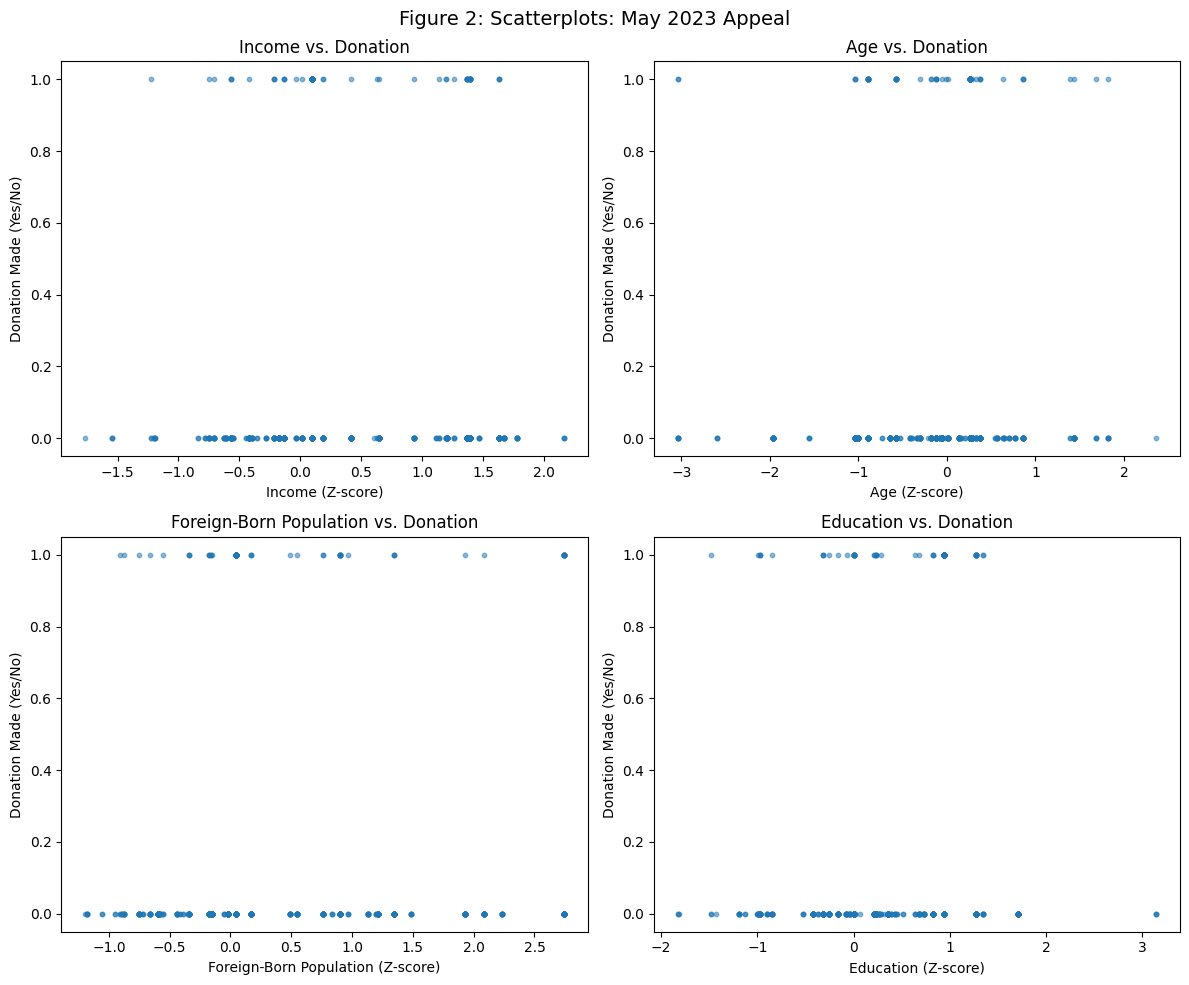

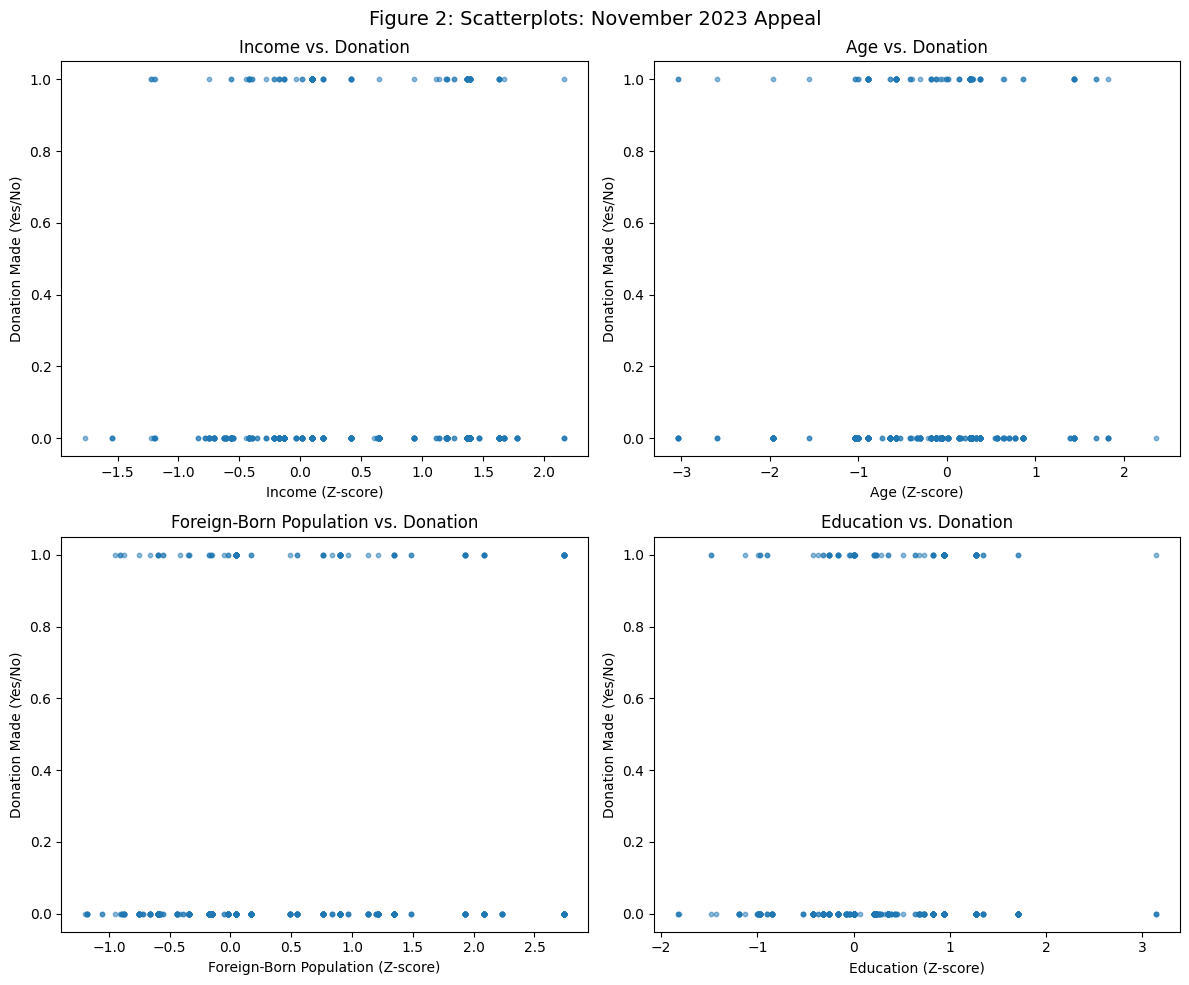

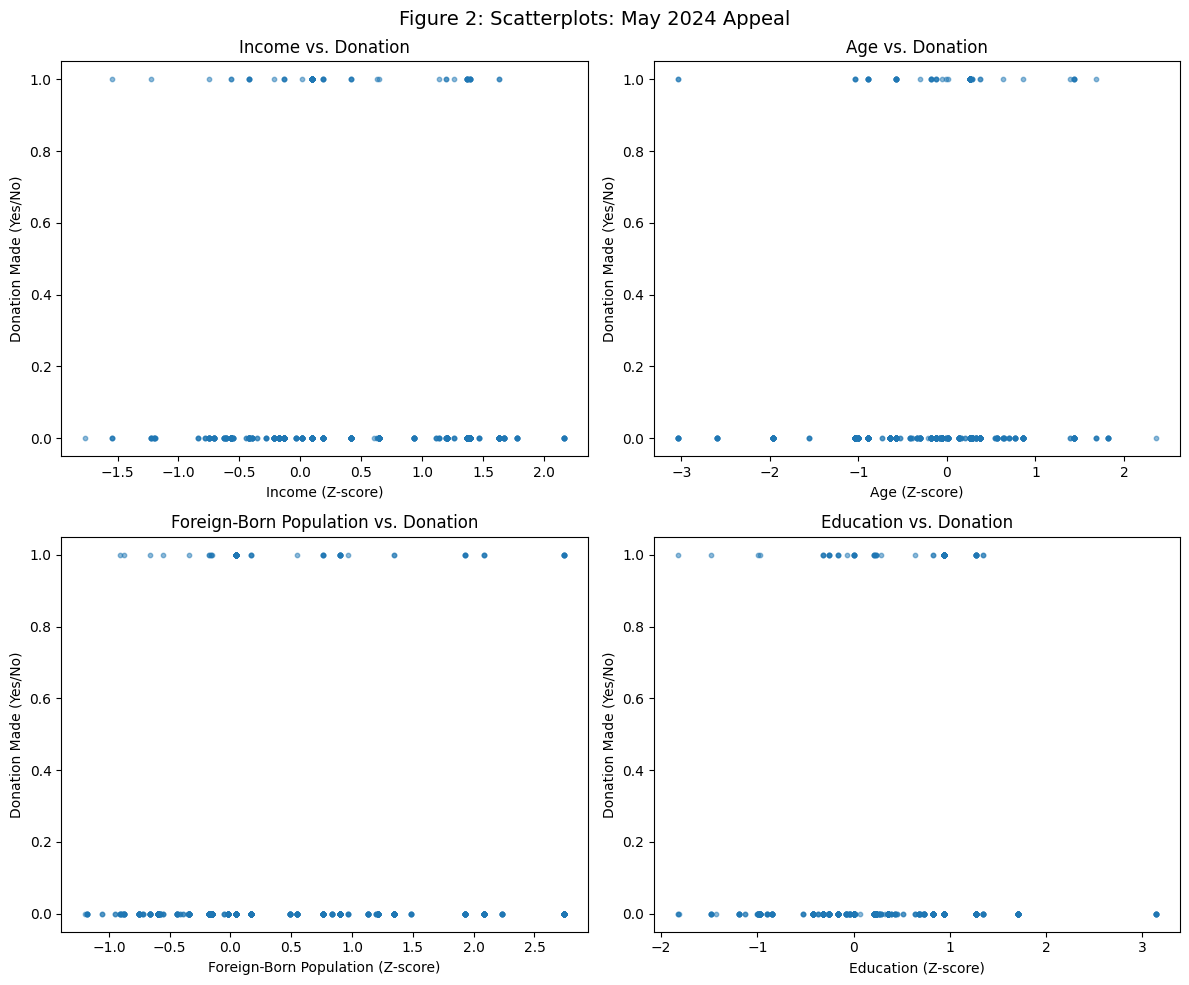

In [22]:
# ============================================================
# FIGURE 2: SCATTERPLOTS
# ============================================================

def create_figure2(df, period_name):
    """
    Create scatterplots of Z-score variables vs. gift.yes.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Figure 2: Scatterplots: {period_name}', fontsize=14)

    # Plot 1: Income vs. Donation
    ax1 = axes[0, 0]
    ax1.scatter(df['z.income'], df['gift.yes'], alpha=0.5, s=10)
    ax1.set_title('Income vs. Donation')
    ax1.set_xlabel('Income (Z-score)')
    ax1.set_ylabel('Donation Made (Yes/No)')

    # Plot 2: Age vs. Donation
    ax2 = axes[0, 1]
    ax2.scatter(df['z.age'], df['gift.yes'], alpha=0.5, s=10)
    ax2.set_title('Age vs. Donation')
    ax2.set_xlabel('Age (Z-score)')
    ax2.set_ylabel('Donation Made (Yes/No)')

    # Plot 3: Foreign-Born Population vs. Donation
    ax3 = axes[1, 0]
    ax3.scatter(df['foreign.born.z'], df['gift.yes'], alpha=0.5, s=10)
    ax3.set_title('Foreign-Born Population vs. Donation')
    ax3.set_xlabel('Foreign-Born Population (Z-score)')
    ax3.set_ylabel('Donation Made (Yes/No)')

    # Plot 4: Education vs. Donation
    ax4 = axes[1, 1]
    ax4.scatter(df['z.edu'], df['gift.yes'], alpha=0.5, s=10)
    ax4.set_title('Education vs. Donation')
    ax4.set_xlabel('Education (Z-score)')
    ax4.set_ylabel('Donation Made (Yes/No)')

    plt.tight_layout()
    plt.show()

create_figure2(all_may23_trimmed, "May 2023 Appeal")
create_figure2(all_nov23_trimmed, "November 2023 Appeal")
create_figure2(all_may24_trimmed, "May 2024 Appeal")

## 13. Logit Regression Models

Replicate the GLM logit regressions from the R analysis.

In [23]:
# ============================================================
# PREPARE DATA FOR MODELING
# ============================================================

# Model variables for individual period regressions
model_vars = ["gift.yes", "z.age", "z.edu", "z.income", "foreign.born.z",
              "gift.past.yes", "State_Tax_Incentive_i"]

# Select columns for each period's model data
all_may23_C = all_may23_trimmed[model_vars].copy()
all_nov23_C = all_nov23_trimmed[model_vars].copy()
all_may24_C = all_may24_trimmed[model_vars].copy()

print(f"May 2023 model data shape: {all_may23_C.shape}")
print(f"November 2023 model data shape: {all_nov23_C.shape}")
print(f"May 2024 model data shape: {all_may24_C.shape}")

May 2023 model data shape: (1434, 7)
November 2023 model data shape: (1469, 7)
May 2024 model data shape: (1586, 7)


In [24]:
# ============================================================
# LOGIT REGRESSION: MAY 2023
# gift.yes ~ z.age + z.edu + z.income + foreign.born.z + gift.past.yes + State_Tax_Incentive_i
# ============================================================

# Define X (independent variables) and y (dependent variable)
X_may23 = all_may23_C[['z.age', 'z.edu', 'z.income', 'foreign.born.z', 'gift.past.yes', 'State_Tax_Incentive_i']]
X_may23 = sm.add_constant(X_may23)  # Add intercept
y_may23 = all_may23_C['gift.yes']

# Fit logit model
logit_may23 = sm.Logit(y_may23, X_may23).fit()

print("=" * 80)
print("LOGIT REGRESSION: MAY 2023")
print("=" * 80)
print(logit_may23.summary())

         Current function value: 0.243429
         Iterations: 35
LOGIT REGRESSION: MAY 2023
                           Logit Regression Results                           
Dep. Variable:               gift.yes   No. Observations:                 1434
Model:                          Logit   Df Residuals:                     1427
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                 0.01644
Time:                        01:55:18   Log-Likelihood:                -349.08
converged:                      False   LL-Null:                       -354.91
Covariance Type:            nonrobust   LLR p-value:                   0.06967
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -22.1583   9401.150     -0.002      0.998   -1.84e+04    1.84e+04
z.age

In [25]:
# ============================================================
# LOGIT REGRESSION: NOVEMBER 2023
# ============================================================

X_nov23 = all_nov23_C[['z.age', 'z.edu', 'z.income', 'foreign.born.z', 'gift.past.yes', 'State_Tax_Incentive_i']]
X_nov23 = sm.add_constant(X_nov23)
y_nov23 = all_nov23_C['gift.yes']

logit_nov23 = sm.Logit(y_nov23, X_nov23).fit()

print("=" * 80)
print("LOGIT REGRESSION: NOVEMBER 2023")
print("=" * 80)
print(logit_nov23.summary())

Optimization terminated successfully.
         Current function value: 0.378604
         Iterations 7
LOGIT REGRESSION: NOVEMBER 2023
                           Logit Regression Results                           
Dep. Variable:               gift.yes   No. Observations:                 1469
Model:                          Logit   Df Residuals:                     1462
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                 0.01361
Time:                        01:55:18   Log-Likelihood:                -556.17
converged:                       True   LL-Null:                       -563.85
Covariance Type:            nonrobust   LLR p-value:                   0.01768
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.0939      0.619     -4.996

In [26]:
# ============================================================
# LOGIT REGRESSION: MAY 2024
# ============================================================

X_may24 = all_may24_C[['z.age', 'z.edu', 'z.income', 'foreign.born.z', 'gift.past.yes', 'State_Tax_Incentive_i']]
X_may24 = sm.add_constant(X_may24)
y_may24 = all_may24_C['gift.yes']

logit_may24 = sm.Logit(y_may24, X_may24).fit()

print("=" * 80)
print("LOGIT REGRESSION: MAY 2024")
print("=" * 80)
print(logit_may24.summary())

Optimization terminated successfully.
         Current function value: 0.217414
         Iterations 8
LOGIT REGRESSION: MAY 2024
                           Logit Regression Results                           
Dep. Variable:               gift.yes   No. Observations:                 1586
Model:                          Logit   Df Residuals:                     1579
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                 0.01822
Time:                        01:55:19   Log-Likelihood:                -344.82
converged:                       True   LL-Null:                       -351.22
Covariance Type:            nonrobust   LLR p-value:                   0.04632
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.7858      0.744     -5.090     

In [27]:
# ============================================================
# TABLE 3: COMBINED REGRESSION RESULTS
# ============================================================

def create_regression_table(models, model_names):
    """
    Create a combined regression results table similar to stargazer output.
    """
    results = []

    for model, name in zip(models, model_names):
        coef_df = pd.DataFrame({
            'Coefficient': model.params,
            'Std. Error': model.bse,
            'z-value': model.tvalues,
            'P>|z|': model.pvalues
        })
        coef_df['Model'] = name
        results.append(coef_df)

    combined = pd.concat(results)
    return combined

# Create combined table
regression_table = create_regression_table(
    [logit_may23, logit_nov23, logit_may24],
    ['May 2023', 'November 2023', 'May 2024']
)

print("=" * 80)
print("Table 3: Logit Regression Results: Donate (Yes/No)")
print("=" * 80)

# Display pivoted table for easier comparison
for var in ['const', 'z.age', 'z.edu', 'z.income', 'foreign.born.z', 'gift.past.yes', 'State_Tax_Incentive_i']:
    print(f"\n{var}:")
    for model, name in zip([logit_may23, logit_nov23, logit_may24], ['May 2023', 'November 2023', 'May 2024']):
        coef = model.params[var]
        se = model.bse[var]
        pval = model.pvalues[var]
        stars = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
        print(f"  {name}: {coef:.4f}{stars} (SE: {se:.4f})")

print("\n" + "=" * 80)
print("Model Fit Statistics:")
print("=" * 80)
for model, name in zip([logit_may23, logit_nov23, logit_may24], ['May 2023', 'November 2023', 'May 2024']):
    print(f"{name}: N={int(model.nobs)}, Log-Likelihood={model.llf:.2f}, Pseudo R²={model.prsquared:.4f}, AIC={model.aic:.2f}")

Table 3: Logit Regression Results: Donate (Yes/No)

const:
  May 2023: -22.1583 (SE: 9401.1498)
  November 2023: -3.0939*** (SE: 0.6192)
  May 2024: -3.7858*** (SE: 0.7438)

z.age:
  May 2023: 0.2923 (SE: 0.1964)
  November 2023: 0.3116* (SE: 0.1579)
  May 2024: 0.2927 (SE: 0.2070)

z.edu:
  May 2023: -0.2421 (SE: 0.2435)
  November 2023: 0.2622 (SE: 0.2064)
  May 2024: 0.1832 (SE: 0.2678)

z.income:
  May 2023: 0.3558 (SE: 0.3213)
  November 2023: -0.3050 (SE: 0.2591)
  May 2024: -0.3754 (SE: 0.3414)

foreign.born.z:
  May 2023: -0.1814 (SE: 0.2092)
  November 2023: 0.2101 (SE: 0.1625)
  May 2024: 0.1958 (SE: 0.2040)

gift.past.yes:
  May 2023: 19.7661 (SE: 9401.1498)
  November 2023: 1.2239* (SE: 0.5966)
  May 2024: 1.3518 (SE: 0.7236)

State_Tax_Incentive_i:
  May 2023: -0.0902 (SE: 0.2854)
  November 2023: -0.2001 (SE: 0.2146)
  May 2024: -0.4617 (SE: 0.2770)

Model Fit Statistics:
May 2023: N=1434, Log-Likelihood=-349.08, Pseudo R²=0.0164, AIC=712.15
November 2023: N=1469, Log-Lik

## 14. Pooled Model with Interaction Terms

In [28]:
# ============================================================
# CREATE POOLED DATASET
# ============================================================

# Variables needed for pooled model
pooled_vars = [
    "gift.yes", "z.age", "z.edu", "z.income", "foreign.born.z",
    "gift.past.yes", "State_Tax_Incentive_i",
    "appeal.health", "appeal.responsibility", "appeal.suggest.amt",
    "appeal.nov", "appeal.message.quality", "gift.amount.1mon.1"
]

# Combine all three periods
pooled_C = pd.concat([
    all_may23_trimmed[pooled_vars],
    all_nov23_trimmed[pooled_vars],
    all_may24_trimmed[pooled_vars]
], ignore_index=True)

print(f"Pooled dataset shape: {pooled_C.shape}")
print(f"\nPooled gift.yes distribution:\n{pooled_C['gift.yes'].value_counts()}")

Pooled dataset shape: (4489, 13)

Pooled gift.yes distribution:
gift.yes
0    4111
1     378
Name: count, dtype: int64


In [29]:
# ============================================================
# POOLED LOGIT REGRESSION WITH INTERACTION TERM
# gift.yes ~ z.age + z.edu + z.income + foreign.born.z + gift.past.yes +
#            State_Tax_Incentive_i + appeal.responsibility + appeal.message.quality +
#            State_Tax_Incentive_i * appeal.message.quality
# ============================================================

# Create interaction term
pooled_C['tax_x_quality'] = pooled_C['State_Tax_Incentive_i'] * pooled_C['appeal.message.quality']

# Define model variables
X_pooled = pooled_C[[
    'z.age', 'z.edu', 'z.income', 'foreign.born.z',
    'gift.past.yes', 'State_Tax_Incentive_i',
    'appeal.responsibility', 'appeal.message.quality', 'tax_x_quality'
]]
X_pooled = sm.add_constant(X_pooled)
y_pooled = pooled_C['gift.yes']

# Fit pooled logit model
logit_pooled = sm.Logit(y_pooled, X_pooled).fit()

print("=" * 80)
print("POOLED LOGIT REGRESSION WITH INTERACTION TERM")
print("=" * 80)
print(logit_pooled.summary())

Optimization terminated successfully.
         Current function value: 0.279197
         Iterations 8
POOLED LOGIT REGRESSION WITH INTERACTION TERM
                           Logit Regression Results                           
Dep. Variable:               gift.yes   No. Observations:                 4489
Model:                          Logit   Df Residuals:                     4479
Method:                           MLE   Df Model:                            9
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                 0.03366
Time:                        01:55:19   Log-Likelihood:                -1253.3
converged:                       True   LL-Null:                       -1297.0
Covariance Type:            nonrobust   LLR p-value:                 5.603e-15
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -5.5274     

## 15. Marginal Effects

In [30]:
# ============================================================
# MARGINAL EFFECTS (Average Marginal Effects)
# Equivalent to R's margins() function
# ============================================================

# Calculate marginal effects at the mean
marginal_effects_pooled = logit_pooled.get_margeff(at='overall')

print("=" * 80)
print("Table 4: Logit Regression Model: Marginal Effects (Pooled Data)")
print("=" * 80)
print(marginal_effects_pooled.summary())

Table 4: Logit Regression Model: Marginal Effects (Pooled Data)
        Logit Marginal Effects       
Dep. Variable:               gift.yes
Method:                          dydx
At:                           overall
                            dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
z.age                      0.0234      0.008      2.915      0.004       0.008       0.039
z.edu                      0.0073      0.010      0.711      0.477      -0.013       0.027
z.income                  -0.0105      0.013     -0.808      0.419      -0.036       0.015
foreign.born.z             0.0075      0.008      0.916      0.360      -0.009       0.023
gift.past.yes              0.1128      0.035      3.244      0.001       0.045       0.181
State_Tax_Incentive_i     -0.0703      0.064     -1.099      0.272      -0.196       0.055
appeal.responsibility      0.0061      0.010      0.603 

## 16. Robustness Checks: Alternative Outcome Variable (1-Month Donations)

In [31]:
# ============================================================
# ROBUSTNESS CHECK: ALTERNATIVE DEPENDENT VARIABLE
# gift.1mon.yes = 1 if gift.amount.1mon.1 > 0, else 0
# ============================================================

# Create alternative dependent variable for each dataset
all_may23_C['gift.1mon.yes'] = np.where(all_may23_trimmed['gift.amount.1mon.1'] > 0, 1, 0)
all_nov23_C['gift.1mon.yes'] = np.where(all_nov23_trimmed['gift.amount.1mon.1'] > 0, 1, 0)
all_may24_C['gift.1mon.yes'] = np.where(all_may24_trimmed['gift.amount.1mon.1'] > 0, 1, 0)
pooled_C['gift.1mon.yes'] = np.where(pooled_C['gift.amount.1mon.1'] > 0, 1, 0)

print("Alternative dependent variable 'gift.1mon.yes' created.")
print(f"\nMay 2023 gift.1mon.yes distribution:\n{all_may23_C['gift.1mon.yes'].value_counts()}")
print(f"\nNovember 2023 gift.1mon.yes distribution:\n{all_nov23_C['gift.1mon.yes'].value_counts()}")
print(f"\nMay 2024 gift.1mon.yes distribution:\n{all_may24_C['gift.1mon.yes'].value_counts()}")
print(f"\nPooled gift.1mon.yes distribution:\n{pooled_C['gift.1mon.yes'].value_counts()}")

Alternative dependent variable 'gift.1mon.yes' created.

May 2023 gift.1mon.yes distribution:
gift.1mon.yes
0    1382
1      52
Name: count, dtype: int64

November 2023 gift.1mon.yes distribution:
gift.1mon.yes
0    1373
1      96
Name: count, dtype: int64

May 2024 gift.1mon.yes distribution:
gift.1mon.yes
0    1538
1      48
Name: count, dtype: int64

Pooled gift.1mon.yes distribution:
gift.1mon.yes
0    4293
1     196
Name: count, dtype: int64


In [32]:
# ============================================================
# LOGIT REGRESSIONS WITH ALTERNATIVE DEPENDENT VARIABLE
# With error handling for singular matrices
# ============================================================

from numpy.linalg import LinAlgError

# May 2023
try:
    y_may23_1mon = all_may23_C['gift.1mon.yes']
    logit_may23_1mon = sm.Logit(y_may23_1mon, X_may23).fit(disp=0)
    print("✅ May 2023 robustness model fitted successfully")
except (LinAlgError, Exception) as e:
    logit_may23_1mon = None
    print(f"⚠️ May 2023 robustness model failed: {e}")

# November 2023
try:
    y_nov23_1mon = all_nov23_C['gift.1mon.yes']
    logit_nov23_1mon = sm.Logit(y_nov23_1mon, X_nov23).fit(disp=0)
    print("✅ November 2023 robustness model fitted successfully")
except (LinAlgError, Exception) as e:
    logit_nov23_1mon = None
    print(f"⚠️ November 2023 robustness model failed: {e}")

# May 2024
try:
    y_may24_1mon = all_may24_C['gift.1mon.yes']
    logit_may24_1mon = sm.Logit(y_may24_1mon, X_may24).fit(disp=0)
    print("✅ May 2024 robustness model fitted successfully")
except (LinAlgError, Exception) as e:
    logit_may24_1mon = None
    print(f"⚠️ May 2024 robustness model failed: {e}")

# Pooled - using fewer variables to avoid singularity
try:
    y_pooled_1mon = pooled_C['gift.1mon.yes']
    # Use simpler model for pooled data
    X_pooled_simple = pooled_C[['z.age', 'z.edu', 'z.income', 'foreign.born.z',
                                 'gift.past.yes', 'State_Tax_Incentive_i']]
    X_pooled_simple = sm.add_constant(X_pooled_simple)
    logit_pooled_1mon = sm.Logit(y_pooled_1mon, X_pooled_simple).fit(disp=0)
    print("✅ Pooled robustness model fitted successfully")
except (LinAlgError, Exception) as e:
    logit_pooled_1mon = None
    print(f"⚠️ Pooled robustness model failed: {e}")

print("\nRobustness check models completed.")

⚠️ May 2023 robustness model failed: Singular matrix
✅ November 2023 robustness model fitted successfully
✅ May 2024 robustness model fitted successfully
✅ Pooled robustness model fitted successfully

Robustness check models completed.


In [33]:
# ============================================================
# ROBUSTNESS CHECK RESULTS TABLE
# ============================================================

print("=" * 80)
print("Robustness Check: Logit Regression Results with gift.1mon.yes")
print("Dependent Variable: Donation within 1 month (Yes/No)")
print("=" * 80)

# Only include models that were successfully fitted (not None)
models_1mon = []
model_names_1mon = []

if logit_may23_1mon is not None:
    models_1mon.append(logit_may23_1mon)
    model_names_1mon.append('May 2023')

if logit_nov23_1mon is not None:
    models_1mon.append(logit_nov23_1mon)
    model_names_1mon.append('November 2023')

if logit_may24_1mon is not None:
    models_1mon.append(logit_may24_1mon)
    model_names_1mon.append('May 2024')

if logit_pooled_1mon is not None:
    models_1mon.append(logit_pooled_1mon)
    model_names_1mon.append('Pooled')

if len(models_1mon) > 0:
    # Get all variable names from the first successful model
    all_vars = list(models_1mon[0].params.index)

    # Display coefficients for each variable
    for var in all_vars:
        print(f"\n{var}:")
        for model, name in zip(models_1mon, model_names_1mon):
            if var in model.params.index:
                coef = model.params[var]
                se = model.bse[var]
                pval = model.pvalues[var]
                stars = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
                print(f"  {name}: {coef:.4f}{stars} (SE: {se:.4f})")
            else:
                print(f"  {name}: --")

    print("\n" + "=" * 80)
    print("Model Fit Statistics:")
    print("=" * 80)
    for model, name in zip(models_1mon, model_names_1mon):
        print(f"{name}: N={int(model.nobs)}, Log-Likelihood={model.llf:.2f}, Pseudo R²={model.prsquared:.4f}, AIC={model.aic:.2f}")

    print("\nNote: *** p<0.001; ** p<0.01; * p<0.05")
    print("Note: May 2023 model excluded due to singular matrix (insufficient positive cases)")
else:
    print("No robustness models were successfully fitted.")

Robustness Check: Logit Regression Results with gift.1mon.yes
Dependent Variable: Donation within 1 month (Yes/No)

const:
  November 2023: -3.7383*** (SE: 0.7786)
  May 2024: -3.7565*** (SE: 0.7663)
  Pooled: -3.9612*** (SE: 0.5290)

z.age:
  November 2023: 0.1965 (SE: 0.2285)
  May 2024: 0.1219 (SE: 0.2707)
  Pooled: 0.2398 (SE: 0.1428)

z.edu:
  November 2023: 0.8867** (SE: 0.3429)
  May 2024: 0.2729 (SE: 0.3697)
  Pooled: 0.2928 (SE: 0.1921)

z.income:
  November 2023: -1.0227* (SE: 0.4022)
  May 2024: -0.6514 (SE: 0.4763)
  Pooled: -0.4376 (SE: 0.2381)

foreign.born.z:
  November 2023: 0.5868* (SE: 0.2449)
  May 2024: 0.2760 (SE: 0.2748)
  Pooled: 0.2728 (SE: 0.1441)

gift.past.yes:
  November 2023: 0.9062 (SE: 0.7279)
  May 2024: 0.6740 (SE: 0.7319)
  Pooled: 1.0572* (SE: 0.5103)

State_Tax_Incentive_i:
  November 2023: -0.4116 (SE: 0.2915)
  May 2024: -0.5443 (SE: 0.3694)
  Pooled: -0.3845* (SE: 0.1900)

Model Fit Statistics:
November 2023: N=1469, Log-Likelihood=-345.99, Pseudo

In [34]:
# ============================================================
# DETAILED MODEL SUMMARIES FOR ROBUSTNESS CHECKS
# ============================================================

# May 2023
print("=" * 80)
print("LOGIT REGRESSION (gift.1mon.yes): MAY 2023")
print("=" * 80)
if logit_may23_1mon is not None:
    print(logit_may23_1mon.summary())
else:
    print("Model not available (singular matrix - insufficient positive cases)")

# November 2023
print("\n" + "=" * 80)
print("LOGIT REGRESSION (gift.1mon.yes): NOVEMBER 2023")
print("=" * 80)
if logit_nov23_1mon is not None:
    print(logit_nov23_1mon.summary())
else:
    print("Model not available")

# May 2024
print("\n" + "=" * 80)
print("LOGIT REGRESSION (gift.1mon.yes): MAY 2024")
print("=" * 80)
if logit_may24_1mon is not None:
    print(logit_may24_1mon.summary())
else:
    print("Model not available")

# Pooled
print("\n" + "=" * 80)
print("LOGIT REGRESSION (gift.1mon.yes): POOLED")
print("=" * 80)
if logit_pooled_1mon is not None:
    print(logit_pooled_1mon.summary())
else:
    print("Model not available")

LOGIT REGRESSION (gift.1mon.yes): MAY 2023
Model not available (singular matrix - insufficient positive cases)

LOGIT REGRESSION (gift.1mon.yes): NOVEMBER 2023
                           Logit Regression Results                           
Dep. Variable:          gift.1mon.yes   No. Observations:                 1469
Model:                          Logit   Df Residuals:                     1462
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Dec 2025   Pseudo R-squ.:                 0.02451
Time:                        01:55:19   Log-Likelihood:                -345.99
converged:                       True   LL-Null:                       -354.68
Covariance Type:            nonrobust   LLR p-value:                  0.007959
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.

## 17. Export Results

In [35]:
# ============================================================
# EXPORT REGRESSION RESULTS TO CSV
# ============================================================

def extract_model_results(model, model_name):
    """
    Extract model results into a DataFrame.
    """
    results_df = pd.DataFrame({
        'Variable': model.params.index,
        'Coefficient': model.params.values,
        'Std_Error': model.bse.values,
        'z_value': model.tvalues.values,
        'p_value': model.pvalues.values,
        'CI_Lower': model.conf_int()[0].values,
        'CI_Upper': model.conf_int()[1].values
    })
    results_df['Model'] = model_name
    results_df['N'] = model.nobs
    results_df['Log_Likelihood'] = model.llf
    results_df['Pseudo_R2'] = model.prsquared
    results_df['AIC'] = model.aic

    return results_df

# Extract results from all main models
results_may23 = extract_model_results(logit_may23, 'May_2023')
results_nov23 = extract_model_results(logit_nov23, 'November_2023')
results_may24 = extract_model_results(logit_may24, 'May_2024')
results_pooled = extract_model_results(logit_pooled, 'Pooled')

# Combine all results
all_results = pd.concat([results_may23, results_nov23, results_may24, results_pooled], ignore_index=True)

# Save to CSV
all_results.to_csv('logit_regression_results.csv', index=False)

print("Regression results exported to 'logit_regression_results.csv'")
print(all_results)

Regression results exported to 'logit_regression_results.csv'
                  Variable  Coefficient  Std_Error  z_value  p_value  \
0                    const     -22.1583  9401.1498  -0.0024   0.9981   
1                    z.age       0.2923     0.1964   1.4886   0.1366   
2                    z.edu      -0.2421     0.2435  -0.9940   0.3202   
3                 z.income       0.3558     0.3213   1.1072   0.2682   
4           foreign.born.z      -0.1814     0.2092  -0.8669   0.3860   
5            gift.past.yes      19.7661  9401.1498   0.0021   0.9983   
6    State_Tax_Incentive_i      -0.0902     0.2854  -0.3161   0.7519   
7                    const      -3.0939     0.6192  -4.9963   0.0000   
8                    z.age       0.3116     0.1579   1.9734   0.0485   
9                    z.edu       0.2622     0.2064   1.2707   0.2038   
10                z.income      -0.3050     0.2591  -1.1771   0.2392   
11          foreign.born.z       0.2101     0.1625   1.2931   0.1960   
12

In [36]:
# ============================================================
# EXPORT DESCRIPTIVE STATISTICS TO CSV
# ============================================================

# Add period identifier and combine
stats_may23['Period'] = 'May_2023'
stats_nov23['Period'] = 'November_2023'
stats_may24['Period'] = 'May_2024'

all_stats = pd.concat([stats_may23, stats_nov23, stats_may24])
all_stats.to_csv('descriptive_statistics.csv')

print("Descriptive statistics exported to 'descriptive_statistics.csv'")

Descriptive statistics exported to 'descriptive_statistics.csv'


## 18. Summary

This notebook has replicated the complete R analysis pipeline including:

1. **Data Loading**: Loaded accounts, gifts, and state characteristics for all three periods
2. **Data Merging**: Full (outer) join of accounts and gifts data
3. **Date Calculations**: Giving length and gift duration using pandas datetime
4. **Feature Engineering**:
   - Z-scores for income, age, education, and foreign-born population
   - Binary flags for appeal characteristics (health, responsibility, suggest amount, November)
   - Past donation indicator
   - Message quality scores
   - State tax incentive variable
5. **Descriptive Statistics**: Summary statistics for all periods
6. **Visualizations**: Bar charts, histograms, and scatterplots
7. **Correlation Analysis**: Pairwise correlations and cross-tabulations
8. **Logit Regression Models**: Individual period models and pooled model with interaction terms
9. **Marginal Effects**: Average marginal effects for pooled model
10. **Robustness Checks**: Alternative dependent variable (1-month donations)